In [58]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso

import pysindy as ps
import pandas as pd
import numpy as np

In [59]:
from stesml.data_tools import get_scenario_index
from stesml.data_tools import get_train_and_val_index
from stesml.data_tools import load_data

In [60]:
data_dir = "../data/Sulfur_Models/heating/heating_all"

In [61]:
scenario_index = get_scenario_index(data_dir)

In [62]:
train_index, val_index = get_train_and_val_index(scenario_index, random_state=5)

In [63]:
train_data = load_data(scenario_index, train_index)

In [64]:
train_df = train_data[['Tw','Ti','Tavg']]

In [65]:
train_df.index = train_data['flow-time']

In [66]:
train_df

,Tw,Ti,Tavg
flow-time,,,
0.000000,540,400.0,400.000000
0.000050,540,400.0,400.000177
0.000100,540,400.0,400.000354
0.000192,540,400.0,400.000680
0.000370,540,400.0,400.001306
...,...,...,...
7199.604681,460,400.0,429.384154
7199.704681,460,400.0,429.384296
7199.804681,460,400.0,429.384439


In [67]:
train_data_list = list()
index_list = list()
for idx, grp in train_df.groupby(["Tw", "Ti"]):
    train_data_list.append(grp.values)
    index_list.append(grp.index.values)

In [68]:
train_data_list[0][:,2]

array([399.99999977, 400.00002467, 400.00004954, ..., 414.02091475,
       414.02096705, 414.02096949])

In [69]:
index_list[1]

array([0.00000000e+00, 5.00000000e-05, 1.00000000e-04, ...,
       7.19983193e+03, 7.19993193e+03, 7.20000000e+03])

In [70]:
np.array(train_data_list[1][:,2][0]).reshape(1)

array([399.99999977])

In [71]:
sparse_regression_optimizer = ps.STLSQ(threshold=0, normalize_columns=True)
model = ps.SINDy(optimizer=sparse_regression_optimizer)

In [86]:
model.fit(train_data_list[0:2], t=index_list[0:2], multiple_trajectories=True)
model.print()

(x0)' = 0.000
(x1)' = 0.000
(x2)' = 22.201 1 + -40374.339 x0 + 8952.552 x1 + 242.070 x2 + 3001188.487 x0^2 + -6452454.311 x0 x1 + 3466350.321 x1^2 + -0.605 x1 x2


In [88]:
res = model.simulate(x0=np.array(train_data_list[1][0]).reshape(3),t=index_list[1][0:200])

In [89]:
res[:,2]

array([399.99999977, 400.0000006 , 400.00000144, 400.00000298,
       400.00000595, 400.0000119 , 400.00002378, 400.00004752,
       400.00009508, 400.00019016, 400.00035997, 400.0006496 ,
       400.00114142, 400.0019759 , 400.00337201, 400.00503217,
       400.00669233, 400.00835248, 400.01001264, 400.0116728 ,
       400.01333389, 400.01501846, 400.01670303, 400.01838733,
       400.02005938, 400.02173175, 400.02340411, 400.02506472,
       400.02672488, 400.02838503, 400.03004519, 400.03170534,
       400.0333655 , 400.03504624, 400.03673074, 400.0384151 ,
       400.04008754, 400.04175822, 400.04341838, 400.04507854,
       400.0467387 , 400.04839885, 400.05005901, 400.05171916,
       400.05337732, 400.05505059, 400.05672983, 400.0584023 ,
       400.06007467, 400.06173515, 400.06339531, 400.06505547,
       400.06671562, 400.06837578, 400.07003594, 400.07169599,
       400.07334396, 400.07500312, 400.07667548, 400.07834785,
       400.08002021, 400.08168749, 400.08334765, 400.08

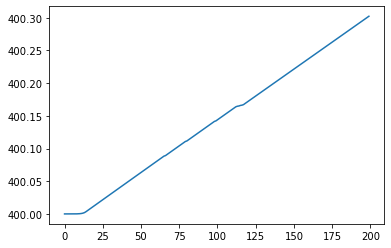

In [91]:
plt.plot(res[:,2])

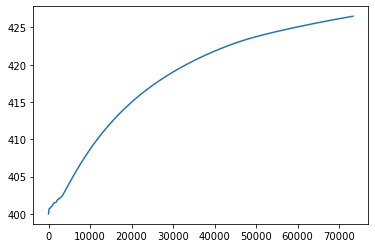

In [76]:
plt.plot(train_data_list[1][:,2])

In [78]:
train_data_list[1][:,2]

array([399.99999977, 400.0000498 , 400.00009979, ..., 426.4899895 ,
       426.4900862 , 426.49015203])

In [92]:
plt.plot(train_data_list[1][:,2] - res[:,2])

ValueError: operands could not be broadcast together with shapes (73305,) (200,) 